In [1]:
!pip install pytorch_lightning
# !pip install faiss-gpu
!pip install tensorboardX
!pip install torch_geometric

You should consider upgrading via the '/Users/sergey.malyshev/.pyenv/versions/3.8.16/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/sergey.malyshev/.pyenv/versions/3.8.16/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/sergey.malyshev/.pyenv/versions/3.8.16/bin/python3.8 -m pip install --upgrade pip' command.


In [1]:
from collections import namedtuple

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

import pytorch_lightning as pl

import tqdm
import json
import sklearn.metrics as sm

import tensorboardX as tb
# import tensorflow as tf
import datetime, os

import matplotlib.pyplot as plt
import seaborn as sns
import torch_geometric.data as pyg_data
import torch_geometric.utils as pyg_utils
import torch_geometric.nn as pyg_nn
import seaborn as sns
import faiss
import shutil

from sklearn.model_selection import train_test_split

np.random.seed(31337)

# Нейросетевая коллаборативная фильтрация с использованием графовой модели

**Кратко о LightGCN**

В рамках семинара мы будем использовать модель LightGCN. Данная модель является следующим этапом развития модели NGCF, которая была одной из первых проб пера в прикручивании графовых моделей к рекомендательным системам. NGCF страдала от большого количества избыточных параметров и от тяжелого инференса. Авторы LightGCN, придерживаясь парадигмы *бритвы Оккама* прошлись по архитектуре NGCF и вырезали все лишнее, оставив только важные компоненты. В итоге модель избавилась от всех параметров кроме таблицы эмбеддингов, формулы также значительно упростились.

**Артитектура LightGCN**

Как ранее упомяналось, среди параметров модели присутствует только таблица эмбеддингов (таблица пользователей и таблица айтемов). Вся специфика LightGCN - в том, как осуществляется ее инференс.

В LightGCN есть понятие слоя, который, в отличие от классических нейросетей прямого распространения не имеет параметров. Слой LightGCN выглядит следующим образом,

$$e_i (k+1) = \sum_{ j \in N(i) }{ \frac{1}{\sqrt(\deg(i) * \deg(j)) } * e_j(k) },$$

где $i$ - идентификатор узла, $(k)$ - номер слоя, $N(i)$ - соседи узла i, $e_i(k)$ - k-й слой в узле i. При этом, слой $e(0)$ является "сырым" эмбеддингом из таблицы эмбеддингов. В то время как для расчета "финальных" эмбеддингов используется следующая формула.

$$e_i = \sum_{k=0}^{K}{\alpha * e_i(k)}$$

Для инференса модели используется скалярное произведение "финальных" эмбеддингов пользователя и айтема, то есть:

$$\hat{y} = (e_u, e_i)$$

Архитектура LightGCN представлена на рисунке ниже.


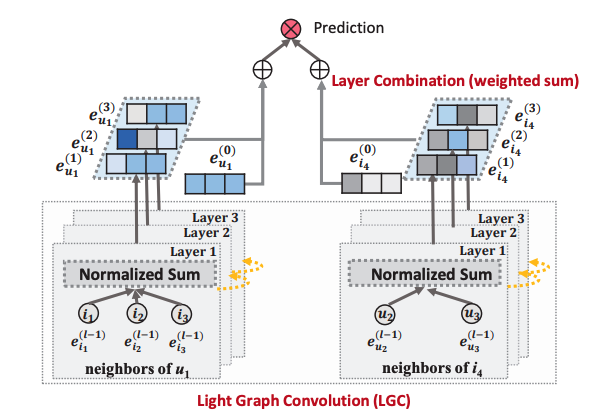

**Обучение**

Обучение LightGCN выполняется с использованием BPR лосса, который выглядит следующим образом,

$$\mathbf{L} = \sum_{u \in U}\sum_{i^+ \in I^+(u)}\sum_{i^- \in I^-(u)} \sigma((e_u, e_i^+) - (e_u, e_i^-)) + \lambda||\mathbf{E}(0)||^2,$$

где $U$ - множество пользователей, $I^+(u)$ - айтемы, с которыми пользователь "положительно" провзаимодействовал, $I^-(u)$ - айтемы, с которыми пользователь "отрицательно" провзаимодействовал, $\mathbf{E}(0)$ - исходная таблица эмбеддингов.

# Загрузка и предобработка данных

Подгрузим данные, на которых обучали модель _Neural Collaborative Filtering_, а также выполним предварительную подготовку.

In [4]:
import glob

In [5]:
DATA_DIR = "/Users/sergey.malyshev/projects/edu/2025-itmo-recsys/"

In [6]:
data = pd.concat([
    pd.read_json(data_path, lines=True) 
    for data_path 
    in glob.glob(DATA_DIR + "/data_10k/*/data.json")
])

In [7]:
data.shape

(961131, 8)

<Axes: >

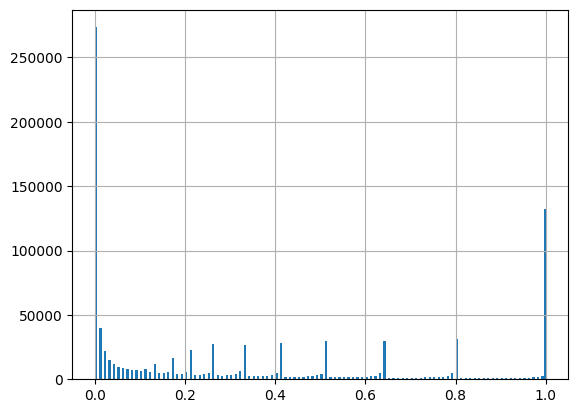

In [8]:
data["time"].hist(bins=200)

In [9]:
# Отберем только треки которые прослушали минимум на 80%
positives = data[data["time"] > 0.8].copy()

# Отберем треки, которые прослушали минимум 5 раз.
track_counts = positives["track"].value_counts()
distinct_tracks = set(track_counts[track_counts >= 5].index.values)
data_filt = positives[positives["track"].isin(distinct_tracks)]
distinct_users = set(data_filt['user'])

print(f"Взаимодействий: {len(data_filt)}")
print(f"Уникальных треков: {len(distinct_tracks)}")
print(f"Уникальных пользователей: {len(distinct_users)}")

Взаимодействий: 94565
Уникальных треков: 11228
Уникальных пользователей: 9988


В *data_filt* содержатся взаимодействия пользователей с треками. При этом, для идентификации треков и пользователей используются UserID, TrackID. Как среди UserID, так и среди TrackID могут иметь место гапы, из-за которых могут возникнуть дыры в таблице эмбеддингов.


По этой причине смаппим айдишники на индексы, начинающиеся с 0 и заканчивающиеся максимальным количеством пользователей / треков.

In [10]:
data_filt_sorted = data_filt[['user', 'track']].sort_values(by=['user'])

track_ids = np.sort(np.unique(data_filt_sorted['track']))
user_ids = np.sort(np.unique(data_filt_sorted['user']))

track_ix = np.searchsorted(track_ids, data_filt_sorted['track'].values)
user_ix = np.searchsorted(user_ids, data_filt_sorted['user'].values)

In [11]:
NUM_USERS = len(user_ids)
NUM_TRACKS = len(track_ids)
NUM_NODES = NUM_USERS + NUM_TRACKS

# Поскольку модель LightGCN из пакета PyG работает с гомогенными графами (один тип узлов), то
#  нам нужно как-то объединить узлы пользователей и треков без коллизий по индексам. Для этого идентификатору
#  узла каждого трека добавим сдвиг равный числу пользователей.
NODE_LABEL_SHIFT = NUM_USERS

print(f"Уникальных треков: {NUM_TRACKS}")
print(f"Уникальных пользователей: {NUM_USERS}")

Уникальных треков: 11228
Уникальных пользователей: 9988


In [12]:
assert (user_ids[user_ix] == data_filt_sorted['user'].values).min()
assert (track_ids[track_ix] == data_filt_sorted['track'].values).min()

Формируем следующие списки ребер графа:
1. user_item_interactions := ($item \rightarrow user$)
2. item_user_interactions := ($user \rightarrow item$)

Для обучения и инференса LightGCN нам потребуется объединение user_item_interactions и item_user_interactions, соответственно определим дополнительно переменную:
3. all_interactions := ($item \rightarrow user$) $\cup$ ($user \rightarrow item$)


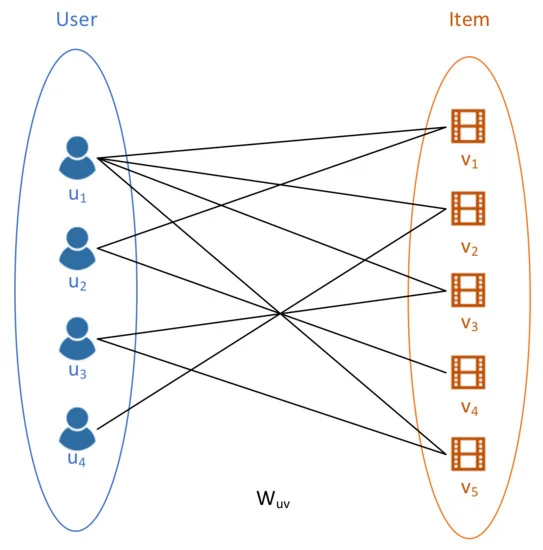

In [13]:
user_item_interactions = torch.stack([
    torch.from_numpy(user_ix),
    # Сдвинем индексы узлов треков во избежание коллизий с узлами пользователей.
    torch.from_numpy(track_ix + NODE_LABEL_SHIFT)
])

item_user_interactions = torch.stack([
    user_item_interactions[1, :],
    user_item_interactions[0, :]
])

all_interactions = torch.cat([
    user_item_interactions,
    item_user_interactions
], axis = 1)

In [14]:
user_item_interactions

tensor([[    0,     0,     0,  ...,  9987,  9987,  9987],
        [20746, 12412, 19566,  ..., 18606, 18845, 18845]])

In [18]:
user_item_interactions.shape

torch.Size([2, 94565])

In [16]:
item_user_interactions

tensor([[20746, 12412, 19566,  ..., 18606, 18845, 18845],
        [    0,     0,     0,  ...,  9987,  9987,  9987]])

In [19]:
item_user_interactions.shape

torch.Size([2, 94565])

In [17]:
all_interactions

tensor([[    0,     0,     0,  ..., 18606, 18845, 18845],
        [20746, 12412, 19566,  ...,  9987,  9987,  9987]])

In [20]:
all_interactions.shape

torch.Size([2, 189130])

Определим датасет и даталоадер для удобной работы с датасетом через интерфейс Pytorch Lightning. Датасет представляет собой пары $user \rightarrow item$.

Класс **NegativeSamplingDataset** позволяет индексировать датасет. При обращении по индексу помимо положительного взаимодействия пользователь-трек (**P**) возвращается пара негативного взаимодействия пользователь-трек (**N**). Пара N генерируется и спользованием т.н. **негативного семплирования**. Негативное семплирование - это семейство стратегий для генерации негативных взаимодействий для обучения коллаборативных моделей на данных, в которых содержатся только позитивные взаимодействия.

In [23]:
SAMPLE_POSITIVE = 0
SAMPLE_NEGATIVE = 1

class NegativeSamplingDataset(td.Dataset):
  def __init__(self, user_track_interactions, index_subset=None, transform=None):
    # Подмножество индексов (для разбиения train / test)
    self.index_subset = index_subset
    # Все позитивные взаимодействия нашего датасета
    self.positive_edges_full_batch = user_track_interactions
    # Все негативные взаимодействия нашего датасета
    self.negative_edges_full_batch = None

    # Позитивные и негативные взаимодействия в срезе подмножества индексов
    self.positive_edges_sample = None
    self.negative_edges_sample = None

    # Сохраниим все позитивные взаимодействия нашего датасета
    self.init()

  def generate_negative_sample(self):
    # Сгенерируем негативные семплы. На каждого user в парах user -> item(+)
    #   генерируется пара user -> item(-). Подробнее о работе метода можно почитать по ссылке.
    # https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html#torch_geometric.utils.structured_negative_sampling
    user_index, _, negative_item_index = \
      pyg_utils.structured_negative_sampling(self.positive_edges_full_batch, num_nodes=NUM_TRACKS)

    self.negative_edges_full_batch = torch.stack([
        user_index,
        negative_item_index
    ])

  def init(self):
    self.generate_negative_sample()

    # Получим положительные и негативные взаимодействия в срезе индексов для разбиения train / test.
    self.positive_edges_sample = self.positive_edges_full_batch[:, self.index_subset]
    self.negative_edges_sample = self.negative_edges_full_batch[:, self.index_subset]

  def __len__(self):
    return self.positive_edges_sample.shape[1]

  def __getitem__(self, idx):
    return (
        self.positive_edges_sample[:, idx],
        self.negative_edges_sample[:, idx]
    )

# Функция для объединения данных в батч, используемая в DataLoader
def collate_edges(edges: list) -> tuple:
    positive_edges = [edge[SAMPLE_POSITIVE] for edge in edges]
    negative_edges = [edge[SAMPLE_NEGATIVE] for edge in edges]

    positive_edges = torch.stack(positive_edges).t()
    negative_edges = torch.stack(negative_edges).t()

    return positive_edges.to('cpu'), negative_edges.to('cpu')

train_ix, val_ix = train_test_split(np.arange(len(track_ix), dtype=np.int32), test_size=0.1)

music_dataset_train = NegativeSamplingDataset(user_item_interactions, train_ix)
music_dataset_val = NegativeSamplingDataset(user_item_interactions, val_ix)

music_dataloader_train = td.DataLoader(music_dataset_train, batch_size=3000, collate_fn = collate_edges)
music_dataloader_val = td.DataLoader(music_dataset_val, batch_size=3000, collate_fn = collate_edges)

**Определяем полезные хуки**
1. MetricTrackerHook - позволяет логировать метрики (в нашем случае - лосс) в конце каждой эпохи.
2. DatasetReloaderHook - позволяет перегенерировать негативные семплы в конце каждой эпохи.

# Обучение

In [24]:
class MetricTrackerHook(pl.Callback):
    def __init__(self):
      self.collection = {
          'train_loss': [],
          'val_loss': []
      }

    def on_train_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule"):
      self.collection['train_loss'].append(trainer.logged_metrics['train_loss'].cpu().detach().numpy().item())

    def on_validation_epoch_end(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule"):
      self.collection['val_loss'].append(trainer.logged_metrics['val_loss'].cpu().detach().numpy().item())


class DatasetReloaderHook(pl.Callback):
  def __init__(self, dataset: NegativeSamplingDataset):
    self.dataset = dataset

  def ok_train_epoch_start(self, trainer: "pl.Trainer", pl_module: "pl.LightningModule"):
    self.dataset.init()

In [25]:
NEGATIVE_SAMPLE_WEIGHT = 1

class GraphCollaborativeModel(pl.LightningModule):
    def __init__(self, all_adjacent_nodes, num_nodes: int, embedding_dim: int, num_layers: int):
        super().__init__()
        self.all_adjacent_nodes = all_adjacent_nodes
        self.gnn = pyg_nn.LightGCN(num_nodes, embedding_dim, num_layers)

    def compute_loss(self, user_item_positive, user_item_negative):
        # В forward метод LightGCN подается матрица смежности в виде (node_i <-> node_j),
        #  а также пары source_node -> dest_node (в нашем случае user -> track). Результатом forward пасса
        #  является скалярное перемножение эмбеддов пользователя и трека, см. формулу.

        pos_edge_ranking = self.gnn(self.all_adjacent_nodes, user_item_positive)
        neg_edge_ranking = self.gnn(self.all_adjacent_nodes, user_item_negative)

        return self.gnn.recommendation_loss(pos_edge_ranking, NEGATIVE_SAMPLE_WEIGHT * neg_edge_ranking)

    def step(self, data, batch_idx, label):
        user_item_positive, user_item_negative = data[0], data[1]

        loss = self.compute_loss(user_item_positive, user_item_negative)
        self.log(label, loss, prog_bar=True, on_step=False, on_epoch=True, batch_size=data[0].shape[1])
        return loss

    def training_step(self, data, batch_idx):
        return self.step(data, batch_idx, "train_loss")

    def validation_step(self, data, batch_idx):
        self.step(data, batch_idx, "val_loss")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'reduce_on_plateau': True,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

In [26]:
# Опрделяем модель
model = GraphCollaborativeModel(all_interactions, NUM_NODES, 128, 4)

# Определяем все нужные нам хуки
checkpoint = pl.callbacks.ModelCheckpoint(monitor='val_loss', save_top_k=1)
metric_tracker = MetricTrackerHook()
dataset_reloader_train = DatasetReloaderHook(music_dataset_train)
dataset_reloader_val = DatasetReloaderHook(music_dataset_val)

# Запускаем обучатор PytorchLightning
trainer = pl.Trainer(
    accelerator='cpu',
    devices=1,
    max_epochs=10,
    callbacks=[
        checkpoint,
        metric_tracker,
        dataset_reloader_train,
        dataset_reloader_val
    ],
    enable_progress_bar=True,
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/sergey.malyshev/projects/edu/2025-itmo-recsys/itmo_recsys_2025/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


In [27]:
# %load_ext tensorboard
# #%reload_ext tensorboard
# %tensorboard --logdir /content/lightning_logs --host localhost

In [28]:
trainer.fit(model, music_dataloader_train, music_dataloader_val)

/Users/sergey.malyshev/projects/edu/2025-itmo-recsys/itmo_recsys_2025/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

  | Name | Type     | Params | Mode 
------------------------------------------
0 | gnn  | LightGCN | 2.7 M  | train
------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.863    Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/Users/sergey.malyshev/projects/edu/2025-itmo-recsys/itmo_recsys_2025/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/sergey.malyshev/projects/edu/2025-itmo-recsys/itmo_recsys_2025/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/sergey.malyshev/projects/edu/2025-itmo-recsys/itmo_recsys_2025/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (29) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.


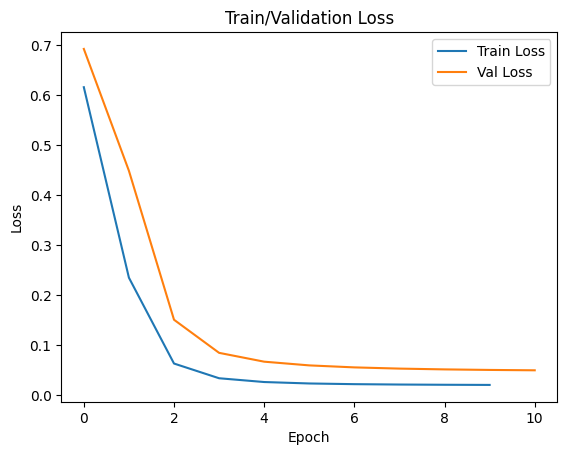

In [29]:
ax = sns.lineplot(metric_tracker.collection['train_loss'], label='Train Loss', legend=True)
sns.lineplot(metric_tracker.collection['val_loss'], label='Val Loss', legend=True)

ax.set_title("Train/Validation Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
pass

In [30]:
shutil.copy(checkpoint.best_model_path, f"{DATA_DIR}/lightgcn.ckpt")

'/Users/sergey.malyshev/projects/edu/2025-itmo-recsys//lightgcn.ckpt'

# Инференс

In [32]:
final_model = GraphCollaborativeModel.load_from_checkpoint(
    f"{DATA_DIR}/lightgcn.ckpt",
    all_adjacent_nodes=all_interactions,
    num_nodes=NUM_USERS + NUM_TRACKS,
    embedding_dim=128,
    num_layers=4
)

Получим эмбеддинги пользователей и айтемов. Помним, что в таблице эмбеддингов лежат эмбеддинги нулевого слоя, который нам не интересен. Поэтому вызываем специальный метод, который расчитает финальные эмбеддинги.

In [33]:
all_embeddings = final_model.gnn.get_embedding(all_interactions.to('cpu'))

user_embeddings = all_embeddings[:NUM_USERS].detach().cpu().numpy().astype('float32')
item_embeddings = all_embeddings[NUM_USERS:].detach().cpu().numpy().astype('float32')

In [35]:
all_embeddings.shape

torch.Size([21216, 128])

In [36]:
user_embeddings.shape

(9988, 128)

In [37]:
item_embeddings.shape

(11228, 128)

In [38]:
assert user_embeddings.shape[0] == NUM_USERS
assert item_embeddings.shape[0] == NUM_TRACKS

Получим рекомендации для пользователей.

In [39]:
NUM_RECOMMENDATIONS = 50

# gpu_res = faiss.StandardGpuResources()
# index_flat = faiss.index_factory(item_embeddings.shape[1], "Flat", faiss.METRIC_INNER_PRODUCT)

# index = faiss.index_cpu_to_gpu(gpu_res, 0, index_flat)
# index.add(item_embeddings)

# scores, recommendations = index.search(user_embeddings, NUM_RECOMMENDATIONS)

# recommendations

In [40]:
index_flat = faiss.index_factory(item_embeddings.shape[1], "Flat", faiss.METRIC_INNER_PRODUCT)

In [41]:
index_flat.add(item_embeddings)

In [42]:
# scores, recommendations = index_flat.search(user_embeddings[:1], NUM_RECOMMENDATIONS)

In [44]:
# scores.shape

In [45]:
# scores

In [46]:
# recommendations

In [47]:
# recommendations.shape

In [48]:
# user_ids.shape

In [49]:
# user_embeddings.astype('float32')[np.newaxis, :][0]

In [50]:
from tqdm import tqdm

In [51]:
scores, recommendations = [], []
for user, user_emb in tqdm(zip(user_ids, user_embeddings), total=len(user_ids)):
    score, recs = index_flat.search(user_emb.astype('float32')[np.newaxis, :], NUM_RECOMMENDATIONS)
    scores.append(score[0])
    recommendations.append(recs[0])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9988/9988 [00:01<00:00, 8877.21it/s]


In [52]:
np.array(recommendations).shape

(9988, 50)

In [54]:
recommendations[0]

array([ 9578, 10748,  7088,  5997,  9286,  5937, 10706, 10117,  2424,
       10496, 10758,  4932,  6109,  3801, 10489,  7191,  7087,  8984,
         585,  5938,  2422,  9631,   719,  3214,  8779,  9070, 10589,
         581,  9176, 10881,  5073,  9288,  3021,  9355,  9017, 10495,
        4708,  9725,   703,  4595, 10590,  9657,  7316,   584,  1133,
        3464,  8490,  8653,  1063,  8069])

In [40]:
# scores, recommendations = index_flat.search(user_embeddings, NUM_RECOMMENDATIONS)

In [41]:
DATA_DIR

'/Users/sergey.malyshev/projects/edu/2025-itmo-recsys/'

In [55]:
with open(DATA_DIR + "/recommendations_gcf.json", "w") as rf:
    for user, recs in tqdm(enumerate(recommendations)):
      rec_user_id = user_ids[user].item()
      rec_track_ids = (track_ids[recs]).tolist()

      recommendation = {
            "user": rec_user_id,
            "tracks": rec_track_ids
        }

      rf.write(json.dumps(recommendation) + "\n")

9988it [00:00, 121699.41it/s]


In [61]:
# track_meta = pd.read_json(f"../botify/data/tracks.json", lines=True)

In [66]:
# writer = tb.SummaryWriter(comment='nn_embeddings', log_dir=f"{DATA_DIR}tb_gcf")
# writer.add_embedding(item_embeddings, metadata=list(track_meta.iloc[track_ids][["artist", "title"]].itertuples(index=False, name=None)), tag="nn", metadata_header=["artist", "title"])
# writer.close()

In [67]:
# f"{DATA_DIR}tb_gcf"

'/Users/sergey.malyshev/projects/edu/2025-itmo-recsys/tb_gcf'